In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
import pickle
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [0]:
def grayscale(im):
    return im.reshape(im.shape[0], 3, 32, 32).mean(1).reshape(im.shape[0], -1)

In [4]:
# Load the data into memory
data, labels = [], []
## Loop over the b
for i in range(1, 6):
    filename = 'gdrive/My Drive/Colab Notebooks/cifar-10-batches-py/data_batch_' + str(i)
    open_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, open_data['data']))
        labels = np.hstack((labels, open_data['labels']))
    else:
        data = open_data['data']
        labels = open_data['labels']

data = grayscale(data)
x = np.matrix(data)
y = np.array(labels)
print(x.shape)

(50000, 1024)


In [5]:
horse_i = np.where(y == 7)[0]
horse_x = x[horse_i]
print(np.shape(horse_x)) 

(5000, 1024)


In [0]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
def plot_image(image, shape=[32, 32], cmap = "Greys_r"):
    plt.imshow(image.reshape(shape), cmap=cmap,interpolation="nearest")
    plt.axis("off")  

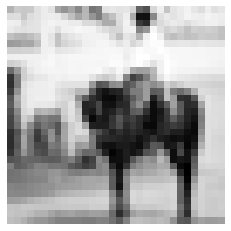

In [7]:
plot_image(horse_x[1], shape=[32, 32], cmap = "Greys_r")

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
(1, 1024)


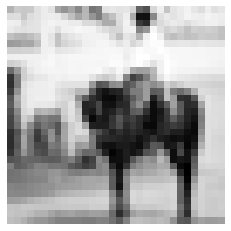

In [8]:
## Parameters
n_inputs = 32 * 32
BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
## Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

## Print the image
with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                         batch_size: BATCH_SIZE}) 
    print(sess.run(features).shape) 
    plot_image(sess.run(features), shape=[32, 32], cmap = "Greys_r")

In [0]:
from functools import partial

## Encoder
n_hidden_1 = 200
n_hidden_2 = 100  # codings

## Decoder
n_hidden_3 = n_hidden_1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

In [10]:
## Define the Xavier initialization
xav_init =  tf.contrib.layers.xavier_initializer()
## Define the L2 regularizer
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
## Create the dense layer
dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=xav_init,
                         kernel_regularizer=l2_regularizer)

In [12]:
## Make the mat mul
hidden_1 = dense_layer(features, n_hidden_1)
hidden_2 = dense_layer(hidden_1, n_hidden_2)
hidden_3 = dense_layer(hidden_2, n_hidden_3)
outputs = dense_layer(hidden_3, n_outputs, activation=None)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
loss = tf.reduce_mean(tf.square(outputs - features))

In [0]:
## Optimize
loss = tf.reduce_mean(tf.square(outputs - features))
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

In [15]:
BATCH_SIZE = 150
### Number of batches :  length dataset / batch size
n_batches = horse_x.shape[0] // BATCH_SIZE
print(n_batches)

33


In [16]:
## Set params
n_epochs = 100

## Call Saver to save the model and re-use it later during evaluation
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # initialise iterator with train data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                          batch_size: BATCH_SIZE})
    print('Training...')
    print(sess.run(features).shape) 
    for epoch in range(n_epochs):       
        for iteration in range(n_batches):
            sess.run(train)
        if epoch % 10 == 0:
            loss_train = loss.eval()   # not shown
            print("\r{}".format(epoch), "Train MSE:", loss_train) 
        #saver.save(sess, "./my_model_all_layers.ckpt") 
    save_path = saver.save(sess, "./model.ckpt")    
    print("Model saved in path: %s" % save_path) 

Training...
(150, 1024)
0 Train MSE: 2863.6428
10 Train MSE: 1792.6427
20 Train MSE: 1514.7784
30 Train MSE: 1406.7626
40 Train MSE: 1394.1823
50 Train MSE: 1482.4424
60 Train MSE: 1619.7136
70 Train MSE: 1463.7917
80 Train MSE: 1430.4425
90 Train MSE: 1482.9819
Model saved in path: ./model.ckpt


In [0]:
test_data = unpickle('gdrive/My Drive/Colab Notebooks/cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
#test_labels = np.array(test_data['labels'])

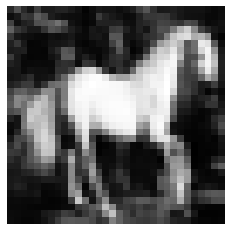

In [18]:
plot_image(test_x[13], shape=[32, 32], cmap = "Greys_r")

In [0]:
def reconstruct_image(df, image_number = 1):
    ## Part 1: Reshape the image to the correct dimension i.e 1, 1024
    x_test = df[image_number]
    x_test_1 = x_test.reshape((1, 32*32))
    
    ## Part 2: Feed the model with the unseen image, encode/decode the image
    with tf.Session() as sess:     
        sess.run(tf.global_variables_initializer()) 
        sess.run(iter.initializer, feed_dict={x: x_test_1,
                                      batch_size: 1})
    ## Part 3:  Print the real and reconstructed image
      # Restore variables from disk.
        saver.restore(sess, "./model.ckpt")  
        print("Model restored.")
      # Reconstruct image
        outputs_val = outputs.eval()
        print(outputs_val.shape)
        fig = plt.figure()
      # Plot real
        ax1 = fig.add_subplot(121)
        plot_image(x_test_1, shape=[32, 32], cmap = "Greys_r")
      # Plot estimated
        ax2 = fig.add_subplot(122)
        plot_image(outputs_val, shape=[32, 32], cmap = "Greys_r")
        plt.tight_layout()
        fig = plt.gcf()

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
(1, 1024)


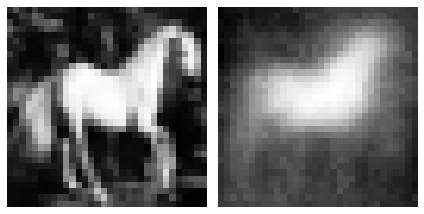

In [20]:
reconstruct_image(df =test_x, image_number = 13)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
(1, 1024)


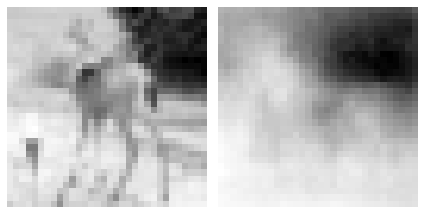

In [21]:
reconstruct_image(df =test_x, image_number = 100)	